# Medical Appointment No-Shows

Author: Jon Kittner

## Purpose

In this tutorial, we will use the data science cycle to analyze medical appointment data from Kaggle and derive insights into what factors go into an appointment "no-show". First, we will read in the data from a csv and do a small amount of modification to the resulting table. Next, we will do some visualization of the data in an exploratory data analysis to see overall trends and develop some hypotheses (this will be the bulk of the tutorial, as there are many different features that are available to visualize for each appointment). Finally, we will do some brief ML to see if we can predict which appointments will be no-shows. Hopefully, this tutorial will help you to understand the significance of medical appointment attendance, what factors may be responsible, and possible policies or practices that could be implemented to improve attendance.

## Background

This may be a data science tutorial, but it's always important to know the background behind the data you are analyzing, and how your conclusions could be used to affect real problems through new programs or policy. Therefore, I'll share a bit about medical appointment and no-shows so you too can get hyped about this important topic.

No-shows, in outpatient clinics, are defined as patients who fail to attend their scheduled clinic appointments without notice or rescheduling. It is a significant target for improving quality of care in outpatient settings as well as for improving overall long-term health of patients. No-shows lead to negative impacts on patient care, productivity, and learning opportunities, as well as longer waiting times for other patients. They also results in a waste of the clinic resources, and physician and other healthcare practitioners' time.

For more background research in this area, I've found a few journal articles that review relevant factors that go into appointment attendance and proposals for policy to increase attendance:

[Why We Don’t Come: Patient Perceptions on No-Shows](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1466756/)

[Reducing Appointment No-Shows: Going from Theory to Practice](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3962267/)

I'll summarize a few relevant findings here:
- Financial reasons play a part in appointment attendance - when patients find out the cost for care, they may choose not to show up
- Long hospital and clinic wait times discourage attendance - a 2014 [survey](https://www.merritthawkins.com/uploadedFiles/MerrittHawkings/Surveys/mha2014waitsurvPDF.pdf) found the average wait time to see a physician in 15 metropolitan areas across the country to be 18.5 days.
- patients who miss appointments tend to be younger, and of lower socioeconomic status, often with a history of failed appointments, government provided health benefits, and psychosocial problems
- Patient satisfaction, including perceived disrespect of patient beliefs and time, has been found to be an important self-reported reason for appointment no-shows

This topic is especially of interest to me, a pre-med student and (hopefully) future doctor. I'm currently working as a scribe in an ER (which involves writing lots of clinic referrals), and it's easy to see the frustration of the providers I work with when they treat patients with a history of failed medical appointments. No-shows are especially important to emergency physicians, as only emergency care is provided in the ER, with follow-up delegated to future clinic visits. Often times, patients with long lasting or chronic health problems will skip follow-up clinic visits for various reasons, including "I didn't think it was bad enough to go to the appointment," and wind up back in the ER once their condition worsens again. Not only are these no-shows bad for the patient health-wise and the clinic providers time-wise, but it puts unnecessary strain on the already scarce ER resources. If we can understand more reason why patients are missing appointments through the magic of data science, we can improve all these problems through targeted policy and practice reform.

P.S. Please attend your medical appointments!!!

## Setup (to the CS stuff!)

This tutorial will be in python, so you will need python 3.X, and these libraries:
- pandas
- numpy
- matplotlib
- skikit-learn
- datetime
- graphviz

I did this through Docker, a popular container technology, with the Jupyter Notebook Data Science Stack. With this method, all the libraries will be automatically installed (except graphviz, which you do a pip install as shown). If you also want to use Docker, you can use [these](https://github.com/umddb/cmsc320-fall2017/tree/master/project0) instructions to set up a Jupyter/iPython notebook on Docker. The specifics of Docker, and virtualization/containers in general, are difficult for me to explain in a clear concise manner, so if you want to go above and beyond to learn more, here's a good intro blog post: [Container/VM/Docker Intro](https://medium.freecodecamp.org/a-beginner-friendly-introduction-to-containers-vms-and-docker-79a9e3e119b)

You can also install the [Anaconda](https://docs.anaconda.com/anaconda/install/) python distribution, then use Anaconda's package manager to install the above libraries.

You are also going to need the No-Show dataset from Kaggle [here](https://www.kaggle.com/joniarroba/noshowappointments)

Once you've set up your environment and downloaded the dataset, open a new Jupyter Notebook, install graphviz, and import the following packages:

In [1]:
!pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from datetime import datetime
import graphviz

## The Data (Collection and Processing)

Data collection and processing are the first steps of the data science cycle. Before you can do useful analysis, you must have the data in a useable form. Usually, this might include such steps as scraping data from the web, merging mutliple files, deleting or filling in erroneous or missing data, or changing the data to be in a more useable form (re-organizing it to make analysis smoother). Luckily, the data for this tutorial is all in one place in a nice clean csv file. Furthermore, the data itself is in a pretty useable form already, so the amount of work needed on my part for these particular steps will be relatively low. I'll describe the features of this dataset below.

The data we will be using is a csv file from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) (which is an excellent resource for finding nicely formatted interesting datasets which are categorized by topic) containing information on > 100k medical appointments of the public healthcare system for the capital city of Espirito Santo State in Brazil, Vitoria, and the characteristics of each. While it might have been nice to get a dataset from somewhere in the U.S. due to cultural differences in the healthcare system, it's likely that many trends will be similar in both locations (and as the famous data scientist Mick Jagger once said, ♫ <i>you can't always get what you waaant</i> ♫). Plus, the huge sample size will be good for statistical significance and for training the ML later on.

In [3]:
#load our data into pandas dataframe
appt_df = pd.read_csv("KaggleV2-May-2016.csv")
#print first 5 rows of our data in a human-readable form.
appt_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


So this is what we've got. As you can see, getting data from a csv is super easy, and it fits right into a pandas dataframe. If you are a python newbie like myself, you're probably gunna want to read up a lot on dataframes, as they are widely used in data science for manipulating data during an analysis. You can think of them as a table-like structure with a ton of useful built in functions for data science goodness. Here are some useful links for pandas basics (including dataframes):

- [Intro to pandas data structures](http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/)
- [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html) (official pandas documentation)

The second link also has more complex guides on pandas functionality for more advanced users.

The data is pretty self-explanatory. It's worth noting that while the day the appointment was scheduled on includes a time, the appointment date itself unfortunetely does not. Also, the "scholarship" column is a binary value that displays whether or not the indevidual recieves financial aid from the government (more information [here](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)). Hypertension, diabetes, alchoholism, and SMS recieved are all binary columns as well. The handicap column is not, however, with values 0-4 depending on how many handicaps the person has (ex. visual, mobility, ect.). 

While this data looks good, it's always good to check for missing NaN values to see if you need to delete or fill in some row data.

In [4]:
appt_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Nope, we are good. However, I noticed when reading through some comments on the dataset that there are some erroneous negative age values for some rows. I'll just get rid of those, as well as outliers that are over 100 years old.

In [5]:
appt_df = appt_df[(appt_df.Age >= 0) & (appt_df.Age <= 100)]

I also would like to have the no-show label be binary, to make it simpler to calculate percentages and for the ML later on.

In [6]:
def NSConvert(str):
    return 1 if str == 'Yes' else 0
appt_df['No_show'] = appt_df.apply(lambda row: NSConvert(row['No-show']), axis = 1)
appt_df.drop('No-show', axis=1, inplace=True)

I also want to make a new column for # days in between the appointment scheduling and the appointment date. This is because as it currently stands, if the appointment is a same day appointment, taking the simple difference in the dateTime fields will yield a negative value. We must first convert the string Objects in the date columns to dateTime Object, which contain more eaily accessible information. See [here](https://docs.python.org/2/library/datetime.html) for more info on python dateTime.

In [7]:
appt_df['sDay'] = appt_df.ScheduledDay.apply(np.datetime64)
appt_df['aDay'] = appt_df.AppointmentDay.apply(np.datetime64)
appt_df['wait_days'] = (appt_df.aDay.dt.date - appt_df.sDay.dt.date).dt.days

appt_df.drop('ScheduledDay', axis=1, inplace=True)
appt_df.drop('AppointmentDay', axis=1, inplace=True)

In [8]:
print("Minimum wait days: ", appt_df['wait_days'].min())
print("Maximum wait days: ", appt_df['wait_days'].max())
print("Number of appointments with (wait days < 0): ", len(appt_df[appt_df.wait_days < 0]))

Minimum wait days:  -6
Maximum wait days:  179
Number of appointments with (wait days < 0):  5


There are only 5 appointments with less than 0 days between appointment scheduling and the actual appointment, so I'll just drop those. While I'm at it, I'll drop apptID, as it's useless.

In [9]:
appt_df = appt_df[appt_df.wait_days >= 0]
appt_df.drop('AppointmentID', axis=1, inplace=True)

In [10]:
appt_df.head()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,sDay,aDay,wait_days
0,2.987250e+13,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08,2016-04-29,0
1,5.589978e+14,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27,2016-04-29,0
2,4.262962e+12,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29 16:19:04,2016-04-29,0
3,8.679512e+11,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29 17:29:31,2016-04-29,0
4,8.841186e+12,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29 16:07:23,2016-04-29,0


Finally, I want to make new columns with the day of the week and month for each appointment day. Even though the dateTime object stores this information, having it in it's own column makes certain operations, such as groupBy (shown later), much simpler. I'll be using datetime's [strftime()](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior) function, which can extract tons of useful information about the object as a string. Of note, I'll be representing the weekday as a decimal for ease of sorting the weekdays in chronological rather than lexigraphical order later on (0 is Sun, 6 is Sat). Since I've got all the info I needed out of the original day columns, I can now drop them.

In [11]:
def dayOfWeek(dT):
    return dT.strftime("%w")
appt_df['weekday'] = appt_df.apply(lambda row: dayOfWeek(row['aDay']), axis = 1)

In [12]:
def month(dT):
    return dT.strftime("%b")
appt_df['month'] = appt_df.apply(lambda row: month(row['aDay']), axis = 1)

In [13]:
appt_df.drop('sDay', axis=1, inplace=True)
appt_df.drop('aDay', axis=1, inplace=True)

In [14]:
appt_df.head()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,wait_days,weekday,month
0,2.987250e+13,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,5,Apr
1,5.589978e+14,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,5,Apr
2,4.262962e+12,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,5,Apr
3,8.679512e+11,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,5,Apr
4,8.841186e+12,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,5,Apr


And voila, we are ready to analyze the data!

## Exploratory Data Analysis

For the exploratory data analysis, or EDA, the purpose is to gain insight into trends in the data in order to develop testable hypotheses. Often times, the best way to do this is to visualize the data with graphs and such. We will be using matplotlib, a standard python plotting library. [Here](https://matplotlib.org/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py) is an intro tutorial, and [here](https://matplotlib.org/tutorials/index.html#introductory) is a page containing tutorials for more advanced users. Altough there is a lot info on appointments, almost all the analysis will focus on the no-show label, as that is the purpose of this tutorial. However, you could also use this data to do an analysis on patient demographics and medical information (diabetes, hypertension, handicap) in this city, distribution of appointment information in different neighborhoods of the city, or even distribution of government aid to different neighborhoods in the city.

First, we might as well see the overall number of shows and no shows. I'll use pyplot's [bar charts](https://pythonspot.com/matplotlib-bar-chart/) to visualize.

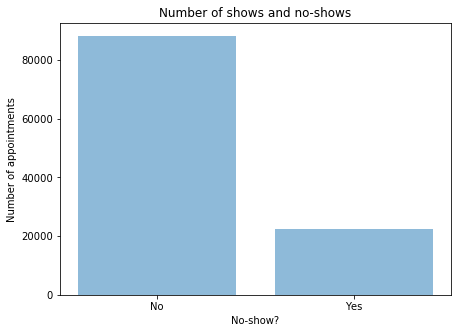

Percentage of No-shows:  0.201883924209


In [15]:
values = []
values.append(appt_df['No_show'].value_counts().get(0)) #shows
values.append(appt_df['No_show'].value_counts().get(1)) #no-shows
              
xVals = ('No', 'Yes')
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(7, 5))
plt.title('Number of shows and no-shows') 
plt.bar(x_pos, values, align='center', alpha=0.5)
plt.xticks(x_pos, xVals)
plt.xlabel('No-show?')
plt.ylabel('Number of appointments')

plt.show()
print("Percentage of No-shows: ", values[1]/appt_df.shape[0])

As we could have predicted, there are quite a lot of no-shows, over 20%. Now, we can look at all the other factors in our table and how they may or may not affect no-show rates. I'll be graphing 
with [subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) to show overall distributions and no-show relationships together. Be cafeful, as for some inexplicable reason the method names for identical graph features are different between subplot Axes and pyplots (so...much...frustration...).

I'll also be using the super-useful python dataframe method groupby. It allows easy grouping of dataframes into different sections based on the value in a certain column. For example, to find the proportion of males/females that were no shows, all I have to do is group by gender, then take the average of the no-show column for each of the groups. The official documentation doesn't do this method justice, so [here](https://chrisalbon.com/python/pandas_apply_operations_to_groups.html) is a great tutorial on using groupby to extract info from a dataframe.

### Gender

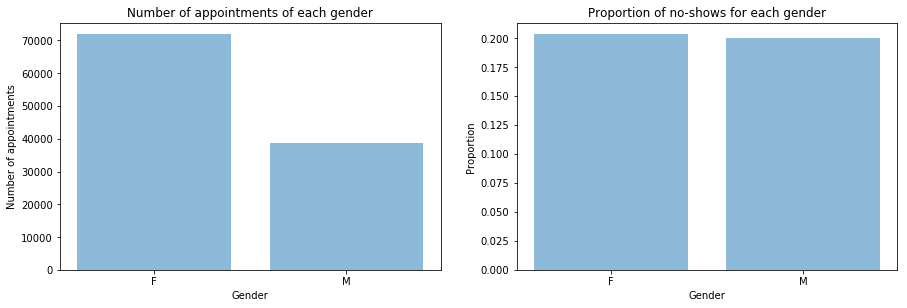

In [16]:
vals1 = []
vals1.append(appt_df['Gender'].value_counts().get('F')) # num females
vals1.append(appt_df['Gender'].value_counts().get('M')) # num males

vals2 = []
vals2.append(appt_df.groupby(['Gender'])['No_show'].mean().get('F'))
vals2.append(appt_df.groupby(['Gender'])['No_show'].mean().get('M'))

xVals = ['F', 'M']
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(15, 10))

sub1 = fig.add_subplot(221)
sub1.set_title('Number of appointments of each gender') 
sub1.bar(x_pos, vals1, align='center', alpha=0.5)
sub1.set_xticks(x_pos)
sub1.set_xticklabels(xVals)
sub1.set_xlabel('Gender')
sub1.set_ylabel('Number of appointments')

sub2 = fig.add_subplot(222)
sub2.set_title('Proportion of no-shows for each gender')
sub2.bar(x_pos, vals2, align='center', alpha=0.5)
sub2.set_xticks(x_pos)
sub2.set_xticklabels(xVals)
sub2.set_xlabel('Gender')
sub2.set_ylabel('Proportion ')

plt.show()

It look like gender doesn't play a large role in no-show percentage. Interestingly enough, there are a lot more female patient appointment than male appointments. This could be due to the gender distribution in the city (unlikely), or randomness in the appointment samples selected (even more unlikely). I have a feeling it might be related to ob/gyn clinic appointments for females, so I can plot female percentage among different age brackets to see if there is a spike in female percentage after reproductive age.

First, we're going to want to bin the ages, as 100 bars is too many to read effectively. Creating 20 bins instead of 100 bars is possible to graph effectively while still retaining some good info on differences between age groups. We do this using [linspace](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linspace.html) to set equally spaced bins, then using [pandas.cut](https://chrisalbon.com/python/pandas_binning_data.html) to add a new column to the dataframe with the associated age bin for each appointment.

In [17]:
bins = np.linspace(0,100,21)
appt_df['binned_age'] = pd.cut(appt_df['Age'], bins)

Next, we need percentages of each age bin that are female. To do this, I first get a list of total numbers of people in each bin and a list of women in each bin using some groupby magic ([Here](https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm) is a good resource for the basics of groupby, but I wish I could say it helped here with extracting info from double groupbys). Then, I divide the lists using zip and a list comprehension.

In [18]:
bin_totals = appt_df.groupby(['binned_age']).size().tolist()
# I basically did a double groupby, then made a list out of every other value(as the second groupby column was gender),so
# the values alternated F then M
bin_females = appt_df.groupby(['binned_age','Gender']).size().get_values()[::2] #this one line took me > 30 minutes

female_percents = [(x*1.0)/y for x, y in zip(bin_females, bin_totals)] # bin_females / bin_totals
print(female_percents)

[0.4739990234375, 0.46458600541541972, 0.54170309494666902, 0.70172110042011115, 0.74014814814814811, 0.74416951080773608, 0.70577862181226259, 0.69318921734600858, 0.7037090698348305, 0.67557861133280128, 0.68783937365829018, 0.68264014466546108, 0.67280606717226432, 0.67110829103214886, 0.66425652310594152, 0.67401574803149611, 0.65286812536960381, 0.70892018779342725, 0.69847328244274809, 0.76923076923076927]


Now we can make the histogram.

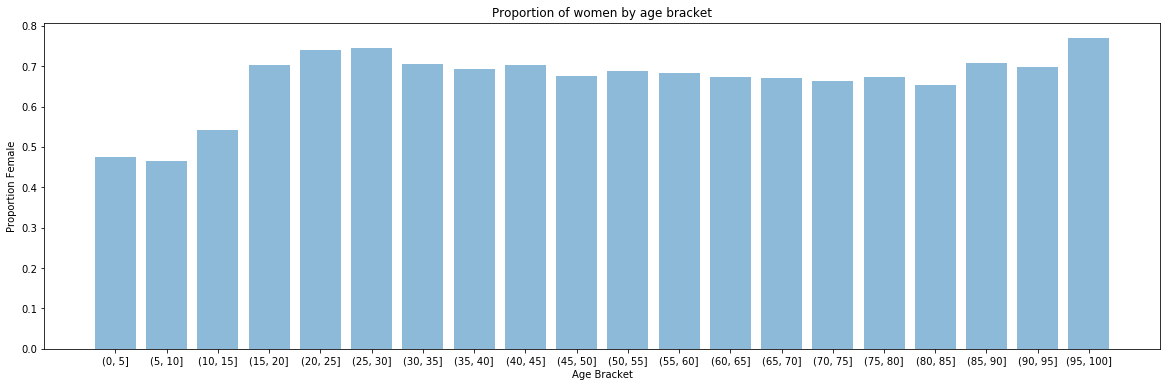

In [19]:
xVals = list(appt_df.groupby(['binned_age']).size().index.values) # a list of bin labels
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(20, 6))
plt.title('Proportion of women by age bracket') 
plt.bar(x_pos, female_percents, align='center', alpha=0.5)
plt.xticks(x_pos, xVals)
plt.xlabel('Age Bracket')
plt.ylabel('Proportion Female')

plt.show()

You can clearly see that the proportion of females at medical appointments starts to rise drastically when reproductive age starts, supporting my previous hypothesis. You can also see an increase again at later years, possibly due to increased overall life expectancy of females compared to males, but also possibly due to lack of samples of patients 85 and older.

As a side note, I was able to fit all the x value labels (the age brackets) on this large graph, but I didn't think I would be able to, so I prepared a useful method for de-cluttering x value labels once they start to overlap. You can hide every nth label using this code to only make every nth label visible on the graph:

In [20]:
# for label in ax.get_xticklabels():
#     label.set_visible(False)
# for label in ax.get_xticklabels()[::n]:
#     label.set_visible(True)

### Age

While wer're at it, we may as well use the binning technique we just used to look at the correlation between age and no-show percentage. I'll also plot the general age distribution on top for reference.

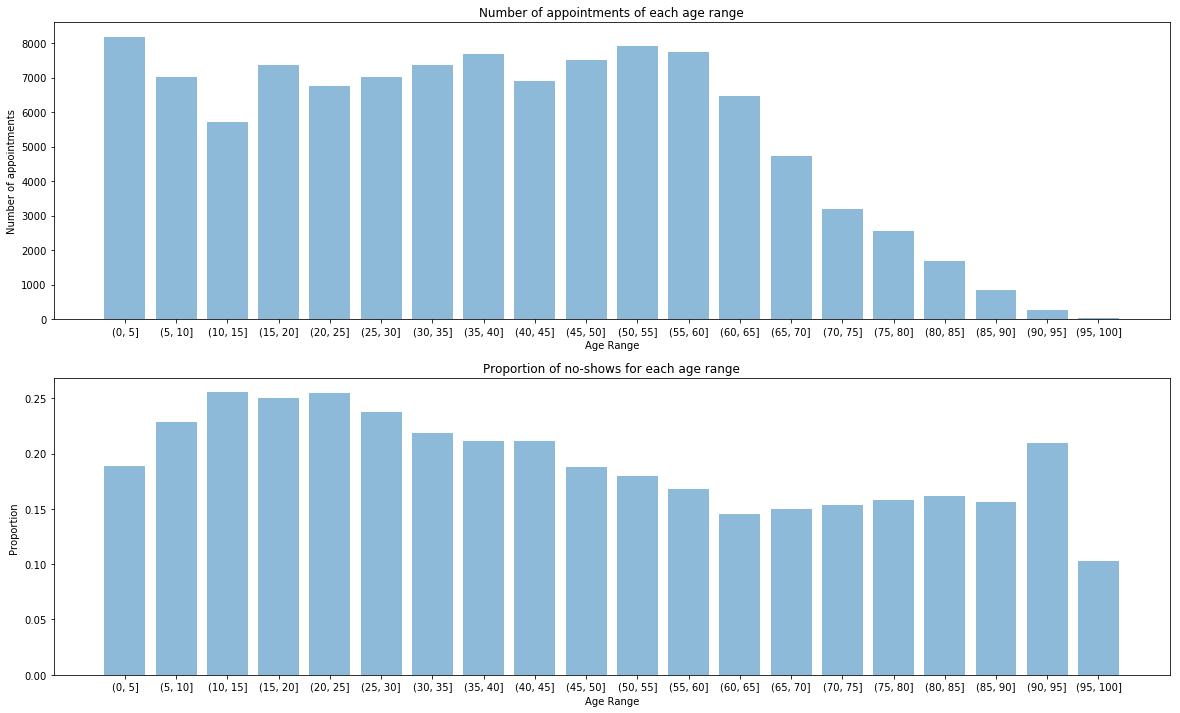

In [21]:
vals1 = appt_df.groupby(['binned_age']).size().tolist() #list of number of appointments per bin

vals2 = appt_df.groupby(['binned_age'])['No_show'].mean().get_values().tolist() # list of no-show percentage for each age range

xVals = list(appt_df.groupby(['binned_age']).size().index.values) # the list of bin labels
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(211)
sub1.set_title('Number of appointments of each age range') 
sub1.bar(x_pos, vals1, align='center', alpha=0.5)
sub1.set_xticks(x_pos)
sub1.set_xticklabels(xVals)
sub1.set_xlabel('Age Range')
sub1.set_ylabel('Number of appointments')

sub2 = fig.add_subplot(212)
sub2.set_title('Proportion of no-shows for each age range')
sub2.bar(x_pos, vals2, align='center', alpha=0.5)
sub2.set_xticks(x_pos)
sub2.set_xticklabels(xVals)
sub2.set_xlabel('Age Range')
sub2.set_ylabel('Proportion ')

plt.show()

These first plot shows a general trend of decreasing number of appointments as age increases (with the exception of a dip during teenage years), starting to fall more rapidly after age 60 (along with general life expectancy). The second plot shows that age is indeed correlated with no-show rate. It seems both young children and the elderly are more likely to show for appointments than the rest of the groups, possibly due to increased concern about health or increased free time due to lack of a job or schooling. This fits with the research showing a major reason for no-shows is that patients feel like they're fine and don't have the time to go to appointments.

### Date of appointment

While patient demographics is one way to check for disparities in no-show rate, we can also look at the appointment time itself to see if it plays a role in no-shows. Earlier, we extracted information from the scheduledDay and appointmentDay columns. We now have month and weekday of the appointment, as well as the number of days a patient must wait between scheduling and attending their appointment. We will now look at these factors.

##### Month

In [22]:
print(appt_df.groupby(['month']).size())

month
Apr     3235
Jun    26448
May    80831
dtype: int64


As you can see, all the data is during a 3 month period. I had thought (due to documentation on Kaggle), that the data was spread over a year+ long period, but it turns out that the newest version of the data containing neighborhood information is from a different sample. I was planning to look for possible seasonal effects in no-show rate, but I'll have to skip that now. Just a lesson to always double-check your data values after importing the data!

#### Weekday

In [23]:
print("Sunday Appointments:", appt_df['weekday'].value_counts().get('0'))
print("Saturday Appointments:", appt_df['weekday'].value_counts().get('6'))

Sunday Appointments: None
Saturday Appointments: 39


You can see there are no appointments on Sunday and only 39 on Saturday, so we will ignore these.

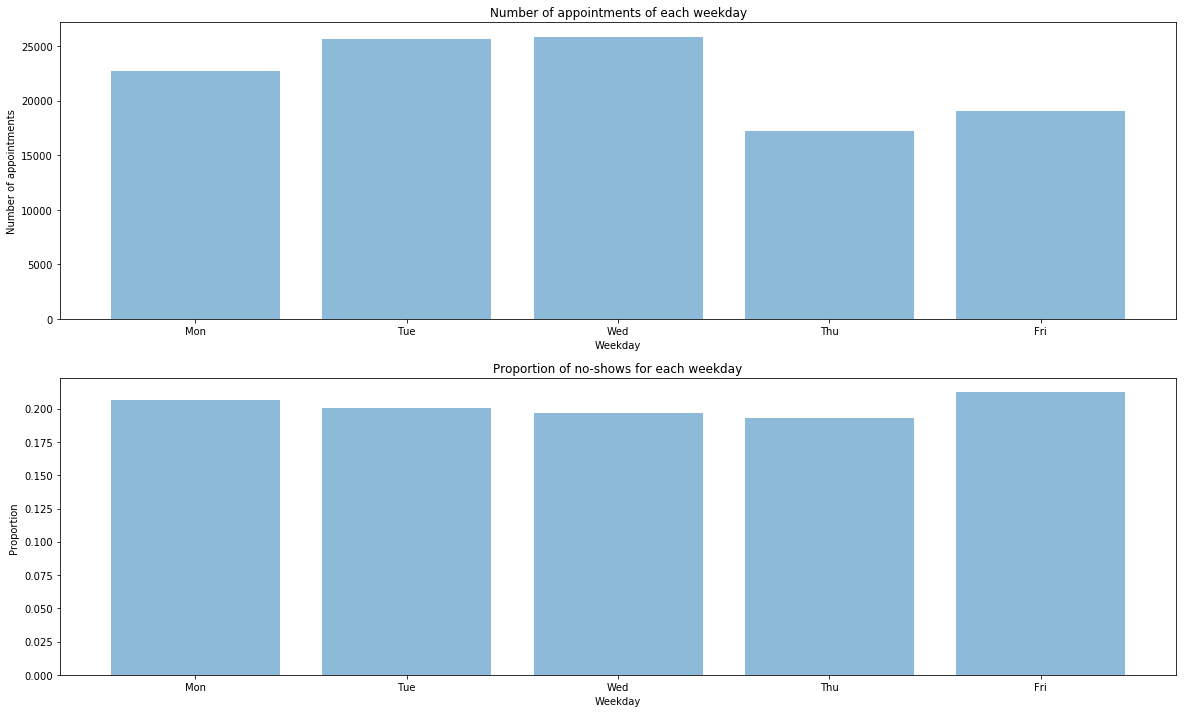

In [24]:
vals1 = appt_df.groupby(['weekday']).size().tolist() #list of number of appointments per weekday
vals1.pop() #remove Sat

vals2 = appt_df.groupby(['weekday'])['No_show'].mean().get_values().tolist() # list of no-show percentage for each weekday
vals2.pop() #remove Sat

xVals = ["Mon", "Tue", "Wed", "Thu", "Fri"] # the list of weekdays (can't plot Sunday since value is 0)
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(211)
sub1.set_title('Number of appointments of each weekday') 
sub1.bar(x_pos, vals1, align='center', alpha=0.5)
sub1.set_xticks(x_pos)
sub1.set_xticklabels(xVals)
sub1.set_xlabel('Weekday')
sub1.set_ylabel('Number of appointments')

sub2 = fig.add_subplot(212)
sub2.set_title('Proportion of no-shows for each weekday')
sub2.bar(x_pos, vals2, align='center', alpha=0.5)
sub2.set_xticks(x_pos)
sub2.set_xticklabels(xVals)
sub2.set_xlabel('Weekday')
sub2.set_ylabel('Proportion ')

plt.show()

You can see appointment numbers decrease on thursdays and fridays. Appointment no-shows decrease slightly over the course of the week, but rise again on friday. While it looks as though clinics are already doing a good job at reducing the number of friday appointments that have higher rates of no-shows, perhaps friday appointments could be prioritized to populations with lower no-show rates, such as young children and the elderly.

#### Wait Time

Wait time is an especially important factor in no-show rates according to the literature. I'll be doing a similar visualization as I did with age groups, except I'd like to try a different method of binning. Due to the extreme skew in waiting times (concentrated around 0 days), I'll be using quantile-based binning using [pandas.qcut](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html)

Update: qcut is a good tool to have, but I ran into some problems. Specifically, when you try to make a lot of bins, but the data is so skewed that bin edges become non-unique (tries to make multiple bins for extremely common values such as 0), qcut breaks. I also can't get the qcut argument "duplicates" to work. See [this post](https://stackoverflow.com/questions/36880490/why-use-pandas-qcut-return-valueerror-bin-edges-must-be-unique/36883735#36883735) for more details. Instead, I'll be using a solution method provided [here(solution 1)](https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges) that combines the contested bins into one. 

Update 2: The solutions provided in the above posts are not correctly separating good-sized bins, and I've spent over 45 minutes on this one problem, so I'm going to create bins manually, check by printing appt_df.groupby(['binned_wait']).size(), then fix the bins manually. For advanced users, I challenge you to find a good solution to this problem!

In [70]:
# manually imputting bin boundaries (I use -.01 as a boudary so I can get a bin with just 0 in it)
bins = [-.01,0,1,2,4,6,8,14,20,27,35,179] 
appt_df['binned_wait'] = pd.cut(appt_df['wait_days'], bins)
# print(appt_df.groupby(['binned_wait']).size()) # used to check bin sizes

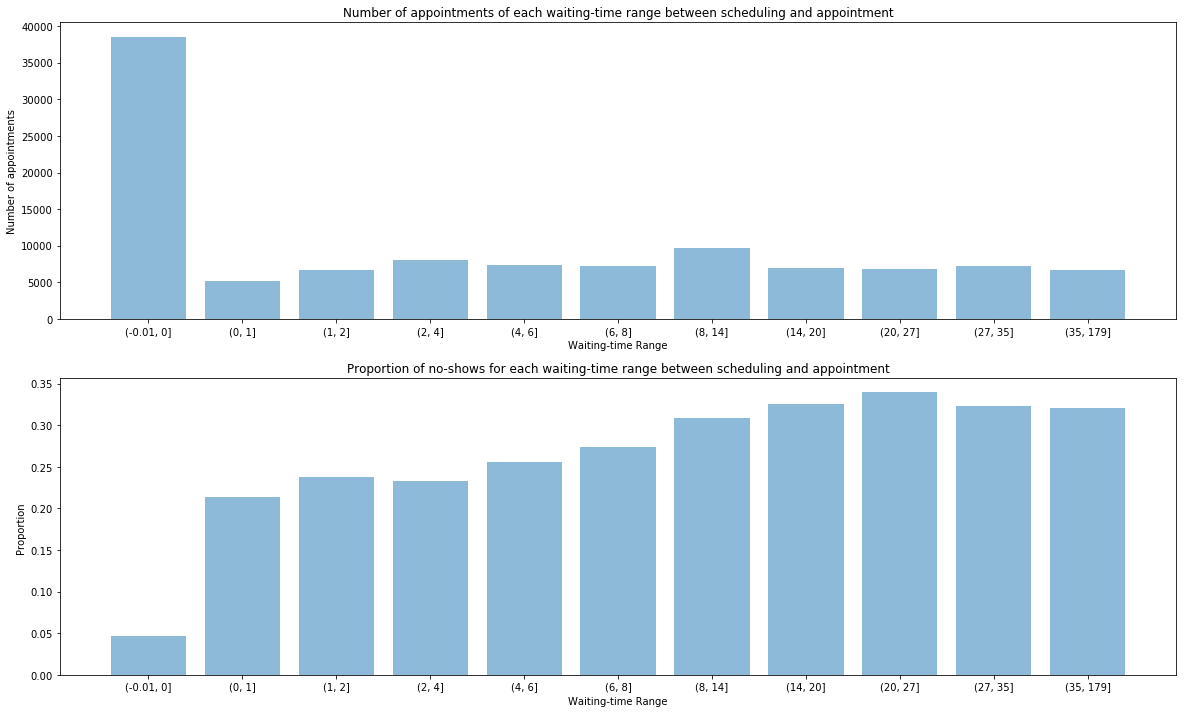

Percent of same-day appointments 0.34891506958394414
Percent of appointments within 1 week 0.640117994100295
Percent of appointments later than 1 week 0.35988200589970504


In [71]:
vals1 = appt_df.groupby(['binned_wait']).size().tolist() #list of number of appointments per bin

vals2 = appt_df.groupby(['binned_wait'])['No_show'].mean().get_values().tolist() # list of no-show percentage for each wait range

xVals = list(appt_df.groupby(['binned_wait']).size().index.values) # the list of bin labels
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(211)
sub1.set_title('Number of appointments of each waiting-time range between scheduling and appointment') 
sub1.bar(x_pos, vals1, align='center', alpha=0.5)
sub1.set_xticks(x_pos)
sub1.set_xticklabels(xVals)
sub1.set_xlabel('Waiting-time Range')
sub1.set_ylabel('Number of appointments')

sub2 = fig.add_subplot(212)
sub2.set_title('Proportion of no-shows for each waiting-time range between scheduling and appointment')
sub2.bar(x_pos, vals2, align='center', alpha=0.5)
sub2.set_xticks(x_pos)
sub2.set_xticklabels(xVals)
sub2.set_xlabel('Waiting-time Range')
sub2.set_ylabel('Proportion ')

plt.show()

print("Percent of same-day appointments", len(appt_df[appt_df['wait_days']==0])/appt_df.shape[0])
print("Percent of appointments within 1 week", len(appt_df[appt_df['wait_days']<=7])/appt_df.shape[0])
print("Percent of appointments later than 1 week", len(appt_df[appt_df['wait_days']>7])/appt_df.shape[0])

The first graph shows that there is a large portion of patients, over 1/3, that get same-day appointments. Extending the waiting time to about a week will include roughly 2/3 of patients, with roughly 1/3 of patients having to wait more than a week for an appointment. 

The results of waiting time on no-show rate are unsurprising. Only 5% of same-day appointments are no-shows, with a general trend of increasing no-show rates as waiting time increases. Keeping the appointment date within a week of scheduling seems to help decrease no-shows significantly, but really any decrease in waiting time below 3 weeks seems to reduce no-shows. The connection to policy is clear: keeping down the number of days from scheduling to appointment will reduce no-shows.

#### SMS

[Studies](https://www.ncbi.nlm.nih.gov/pubmed/20569761/) have shown that outpatient reminder systems are effective in reducing no-show rates. This specific study showed a reduction as a result of both automated and staff calls (STAFF, AUTO, and NONE group no-show rates were 13.6%, 17.3%, and 23.1% respectively). Based on these studies, we might hypothesize that SMS reminders reduce no-show rates as well. Let's find out through visualization, as well as a paired-t test.

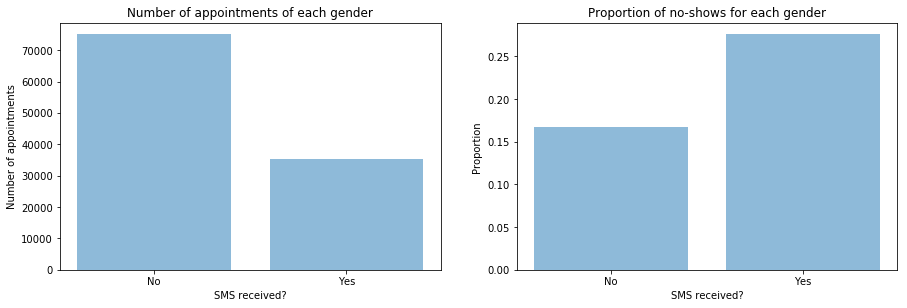

In [27]:
vals1 = []
vals1.append(appt_df['SMS_received'].value_counts().get(0)) # num of people not receiving SMS
vals1.append(appt_df['SMS_received'].value_counts().get(1)) # num of people receiving SMS

vals2 = []
vals2.append(appt_df.groupby(['SMS_received'])['No_show'].mean().get(0)) #proportion of no-shows of people not receiving SMS
vals2.append(appt_df.groupby(['SMS_received'])['No_show'].mean().get(1)) #proportion of no-shows of people receiving SMS

xVals = ['No', 'Yes']
x_pos = np.arange(len(xVals))

fig = plt.figure(figsize=(15, 10))

sub1 = fig.add_subplot(221)
sub1.set_title('Number of appointments of each gender') 
sub1.bar(x_pos, vals1, align='center', alpha=0.5)
sub1.set_xticks(x_pos)
sub1.set_xticklabels(xVals)
sub1.set_xlabel('SMS received?')
sub1.set_ylabel('Number of appointments')

sub2 = fig.add_subplot(222)
sub2.set_title('Proportion of no-shows for each gender')
sub2.bar(x_pos, vals2, align='center', alpha=0.5)
sub2.set_xticks(x_pos)
sub2.set_xticklabels(xVals)
sub2.set_xlabel('SMS received?')
sub2.set_ylabel('Proportion ')

plt.show()

The results are quite surprising. These graphs suggest that < 1/3 of patients receive SMS reminders of appointments, and patients who DO receive SMS reminders have a HIGHER rate of no-shows than those who don't (by a whopping 10%). Logically, this makes no sense at all, and my suspicion is that the data was entered in or labeled wrong (0 for SMS_received field might mean the SMS WAS received). If this is the case, the data will match previous studies showing the effectiveness of reminders in decreasing medical appointment no-shows.

For the purpose of this tutorial, I'll assume the data was mislabeled (0 = received), so I can proceed with a [t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to see if receiving an SMS had a significant effect on no-show rate. T-tests are used to determine if 2 sets of data are significantly different from each other. Specifically, it tests whether the means of two populations are equal (null hypothesis), or if the null can be rejected (the means are different). In this case, the null hypothesis can be thought of as "Receiving an SMS reminder makes no difference on no-show rate," while the alternative hypothesis would be "Receiving an SMS reminder makes a significant difference on no-show rate." For more info on t-tests, [here's](https://www.socialresearchmethods.net/kb/stat_t.php) a good explanatory post.

In [28]:
print(np.var(appt_df[appt_df.SMS_received == 0]['No_show'].values)) #variance of no-show values for those who didn't receive SMS
print(np.var(appt_df[appt_df.SMS_received == 1]['No_show'].values)) #variance of no-show values for those who received SMS

0.139079833843
0.199713381675


The variances of the 2 samples are close enough to do an [independent two-sample t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_equal_variance)

In [29]:
from scipy import stats
received = appt_df[appt_df.SMS_received == 0]['No_show'].values.tolist() #variance of no-show vals for pts not receiving SMS
not_received = appt_df[appt_df.SMS_received == 1]['No_show'].values.tolist() # no-show values for those who received SMS
stats.ttest_ind(received,not_received)

Ttest_indResult(statistic=-42.40939939155362, pvalue=0.0)

Since the p-value is ~0 (smaller than any significance level of .01 , .05, or .10), we can reject the null and conclude that receiving an SMS reminder makes a significant difference on no-show rate. This is result makes sense, as we can see from the graphs that the means in no-show rate are ~10% different.

## ML

Machine learning is kinda what it sounds like. You give a model data, it learns information/connections/relationships from it (training), and it can use the trained model to draw conclusions from new data. In this case, we will be using supervised learning (data with attached labels - ex. No_show) to develop a binary classifier (predicts whether an example is either class A or class B - ex. show or No_show). [Here](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) is a nice visual intro to ML (specifically decision trees, which I will be using). 

In the context of this tutorial, I will be using ML to see if I can find appointment features that are good predictors of whether the patient will show up or not. I also will test the effectiveness of a created model to use these features to predict labels (show or no-show) for unlabeled data (which I take from the dataset and separate the label). 

Before I can begin with the ML, I have to clean up my data a little more. Specifically, I must turn all categorical data into numeric form, as scikit-learn doesn't work well with categorical data. I will be using One Hot Encoding (OHE), or dummy variables, which takes each category value and turns it into a binary vector which is the size of the number of values in the category, where all columns are equal to zero except for the category column. Since that was probably confusing, [here's](https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512) a nice tutorial on OHE. One major downside of OHE is that it drastically increases dimensionality of the data, making training and serving take a lot longer. As a result, I won't try to encode neighborhood, as there are almost 90 different values. I will now do OHE on weekday and handicap (there are 5 values), as well as add a new column based on how many appointments a patient has missed in the past. 

In [30]:
print("Average # of appointments for a patient: ", appt_df.groupby(['PatientId']).size().get_values().mean())

Average # of appointments for a patient:  1.77407133913


First, I'll add the new feature, 'missed'. Since each patient can have multiple appointments, they can also have multiple missed appointments. Logically, it makes sense that a person who has missed more appointments is more likely to miss other appointments. Therefore, 'missed' will encode how many appointments each patient has missed. However, I must be very careful not to fall prey to [Leakage](https://www.kaggle.com/wiki/Leakage), where extra information is included in the training data that allows a model to make unrealistically good predictions. However, I think adding 'missed' is fine, as past patient information would be available to a provider who is writing a new clinic referral. If past no-shows are a good indicator of future no-shows, the provider can use alternate strategies to try to increase the likelihood of the patient showing up to the next clinic visit. 

In [31]:
appt_df['missed'] = appt_df.groupby('PatientId')['No_show'].apply(lambda x: x.cumsum())

There is a problem though. Currently, there is unacceptable leakage, as a no-show appointment includes it's own value in it's missed column. For example, for a patient with only 1 appointment that was a no-show, the missed column is 1 when it should be 0. We only want the missed column to include information about other appointments by the same person, not the result of that particular appointment. Therefore, we will decrement the missed column for all appointments labeled as no-shows.

In [32]:
appt_df.loc[appt_df['No_show'] == 1, 'missed'] = (appt_df['missed'] - 1)

Now, on to OHE and removing unneccessary columns in preparation for the ML.

In [33]:
#drop unneccessary columns
appt_df.drop('PatientId', axis=1, inplace=True)
appt_df.drop('Neighbourhood', axis=1, inplace=True)
appt_df.drop('month', axis=1, inplace=True)
appt_df.drop('binned_age', axis=1, inplace=True)
appt_df.drop('binned_wait', axis=1, inplace=True)

In [34]:
# turn gender into binary variable 
appt_df['Gender'].replace("F", 0,inplace=True)
appt_df['Gender'].replace("M", 1,inplace=True)
appt_df.rename(index=str, columns={"Gender": "male"},inplace=True)

OHE Handicap column

In [35]:
#Convert to Categorical
appt_df['Handcap'] = pd.Categorical(appt_df['Handcap'])
#Convert to Dummy Variables
Handicap = pd.get_dummies(appt_df['Handcap'], prefix = 'Handicap')
appt_df = pd.concat([appt_df, Handicap], axis=1)

appt_df.drop('Handcap', axis=1, inplace=True)

OHE weekday column

In [36]:
#Convert to Categorical
appt_df['weekday'] = pd.Categorical(appt_df['weekday'])
#Convert to Dummy Variables
weekday = pd.get_dummies(appt_df['weekday'], prefix = 'weekday')
appt_df = pd.concat([appt_df, weekday], axis=1)

appt_df.drop('weekday', axis=1, inplace=True)

In [37]:
appt_df.head()

,male,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No_show,wait_days,missed,...,Handicap_1,Handicap_2,Handicap_3,Handicap_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,62,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,56,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Getting into it

On to the ML (finally)! So the first thing you always do when training a classifier is to separate training data from test data. You use the training data to actually train the classifier, and test the trained classifier with the test data. You need to keep the data sets separate because the test data is meant to simulate real world data. If your test data is used to train the model, you can't be sure the model will generalize well to future data. 

In [38]:
# Create arrays for the features and the response variable
Y = appt_df['No_show'].values
X = appt_df.drop('No_show', axis=1).values

# split into train and test data (keep away from that test data !!!)
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.25, random_state=320)

We will be using a decision tree as our classifier. A decision tree basically splits the data recursively at each branch point based on the feature that will give the best separation of classes.  However, we want to limit the maximum depth of branches in the tree, because if we train on too specific of a model, it won't generalize well (overfitting). This tweaking of the max tree depth parameter based on the model makes it a hyperparameter. 

I chose decision tree because they have the advantage of interpretability. Since each branch is based on a single feature, you can tell which features are important enough to branch on. We can also visualize the tree. Furthermore, decision tree model computation doesn't take as long as other models, like SVMs. 

One way to search for a optimal depth is to do a k-fold cross-validation with a range of max_depths to choose from. In a k-fold cross-validation, the data is split into k subsets so that k-1 subsets are used for training and 1 subset is used for validation (i.e., it is used as a test set to compute a performance measure such as accuracy). [Here's](http://scikit-learn.org/stable/modules/cross_validation.html) more on cross validation if you'd like to learn more.

We can use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to do a k-fold cross validation of our training data to find the optimal depth hyperparameter.

Also worth noting, I'll be using f1 scoring instead of the usual accuracy scoring, as it is better when you have highly imbalanced classes (we have ~20% no-shows to ~80% shows). See [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) for more details and suggestions on combatting imbalanced data.

In [39]:
import warnings
warnings.filterwarnings("ignore")

# train the gridsearch model with each of the hyperparameter values with k-fold cross-validation using f1 scoring
def k_fold_cv (X, Y, classifier, param_grid, cv):
    grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=cv, scoring='f1_weighted')
    grid_search.fit(X,Y)
    return grid_search

# get the top n mean scores from gridsearch and their corresponding max_depth hyperparameters
def get_top_n_scores(cv_results, n):
    for i in range(1,n+1):
        index = cv_results['rank_test_score'].tolist().index(i)
        print("Rank: " + str(i))
        print("Mean Test score: " + str(cv_results['mean_test_score'].tolist()[index]))
        print("Max-Depth: " + str(cv_results['params'][index]) + "\n")
    
param_grid = {"max_depth": np.array(range(1, len(X_train[0])))} # test max_depth up to the number of columns
dt_classifier = DecisionTreeClassifier()
grid_search = k_fold_cv(X_train, Y_train, dt_classifier, param_grid, cv = 10)

get_top_n_scores(grid_search.cv_results_, 5)

Rank: 1
Mean Test score: 0.7386230472964053
Max-Depth: {'max_depth': 19}

Rank: 2
Mean Test score: 0.7384999524766689
Max-Depth: {'max_depth': 17}

Rank: 3
Mean Test score: 0.7384500123705681
Max-Depth: {'max_depth': 18}

Rank: 4
Mean Test score: 0.7381773674068975
Max-Depth: {'max_depth': 16}

Rank: 5
Mean Test score: 0.7377828495617207
Max-Depth: {'max_depth': 15}



It looks like even with 10-fold cross validation, the best scores were from the trees with the largest max_depth. However, the mean f1 scores for each value of max_depth were close enough to each other (even down to max_depth=10), that I will use max_depth=10 for my final model for ease of later visualization. Next, I will train a decision tree with the resulting max_depth=10, and see how it deals with the test data.

In [40]:
decision_tree = DecisionTreeClassifier(max_depth = 10) #create tree with hyperparameter
decision_tree.fit(X_train, Y_train) # training

y_pred = decision_tree.predict(X_test) # get predictions of test data

print(metrics.classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.98      0.89     22046
          1       0.51      0.07      0.12      5583

avg / total       0.75      0.80      0.73     27629



At first glance, you can see the overall f1 score (.73) is identical to our f1 score during training. This suggests we didn't overfit the data with our model.

Ah, [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall), our old friends... let's try to interpret these results. Remember that the 0 class on the left is "show" and 1 is "no-show".
    - Precision(show)= .81 - out of those we predicted would show up, 81% actually showed up
    - Precision(no-show)= .51 - out of those we predicted would be no-shows, 51% were actually no-shows
    - Recall(show)= .98 - out of those who showed up(~80% of appointments), we correctly identified 98%
    - Recall(no-show)= .07 - out of those who were no-shows (~20% of appointments), we correctly identified 7%
    
In the case of medical appointment no-shows, what we really care about is recall of no-shows (which this model performed very poorly on). For example, it doesn't really matter that much if we provide extra materials/attention to some people who would have shown up anyways. What really matters is providing those materials to the greatest portion of true no-shows in an attempt to reduce that number. 

In any case, I don't see providers using machine learning to predict whether a patient is likely to miss their appointment any time soon. What is really useful is to know features of patients or appointments that are influential overall in leading to no-shows (such as those we visualized in the EDA earlier), so we can come up with systemic policies and plans to combat the problem at a more global level.

#### Feature importance

For the last part of my ML section, I was planning on displaying a visualization of the decision tree we created using [graphviz](http://dataaspirant.com/2017/04/21/visualize-decision-tree-python-graphviz/). Unfortunately, while I was able to save the image file using Docker, I'm unable to display it in the notebook due to PATH issues (I'll leave that as another quest for you should you choose to accept). FORTUNATELY, not all is lost, as we have tree.feature_importances, a list of feature importances for each feature. The importance of a feature is known as the Gini importance, and is calculated as the normalized total reduction of the criterion (ex. entropy) by a particular feature. These feature importances are arguably better indicators of the significance of a feature for the classifier than looking at the feature splits near the top of the tree with a visualization like graphviz, as they take into account the features' effect on the model as a whole and not just a single split. I'll show the top 5 feature importances below:

In [69]:
features = appt_df.columns.tolist()
features.remove('No_show')
importances = decision_tree.feature_importances_ # get the Gini importances
importances, features = (list(t) for t in zip(*sorted(zip(importances, features),reverse=True))) # grouping and sorting the lists
for i in range(0,5):
    print(features[i], ": with importance",importances[i])

wait_days : with importance 0.641178744666
Age : with importance 0.160296143984
missed : with importance 0.0883135434706
SMS_received : with importance 0.0234499784261
male : with importance 0.0154368958121


Perfect!!! While our model kinda sucked in terms of recall of no-shows, it managed to encode all of the features we previously hypothesized to be relevant for no-show rate during EDA. Specifically, the number of days between scheduling and appointment, age, the number of other appointments missed by the same person, and receipt of an SMS are all important indicators in our model for determining no-show likelihood. 

## Insight and Policy

As explained way up at the top, we need to reduce medical appointment no-show rates to improve patient health, provider productivity, and free up provider resources. To do this, we need to understand the reasons behind no-shows to allow for a targeted approach. In this analysis, we found support for the hypotheses that 
    - 1. no-show rates increase the longer patients have to wait after scheduling
    - 2. young children and the elderly have lower rates of no-shows
    - 3. receipt of an SMS significantly decreases no-show rates (assuming the data was mislabeled as previously mentioned)
    - 4. the likelihood a patient will miss an appointment is related to their number of other missed appointments 
    
I also mentioned some ways this information could be used to influence policy. For example, we saw that no-show rates increased on friday, so perhaps young children and the elderly (more likely to show) could be prioritized for appointments on that day. Also, appointment reminders clearly have a significant impact on attendance, so we could try to send SMS reminders to the 1/3 of patients that were shown not to receive one. Finally, providers and other health workers could focus more on people with a past history of missed appointments, perhaps through specialized materials or personal reminders (the research article I linked on call reminders showed that personal staff calls reduced no-show rate 4% _more_ than automatic reminders).

Thanks for reading my tutorial, and I hope you learned something new about either data science techniques or medical appointments!

## Further Resources

Hopefully I posted enough links to material relevant to both medical no-show literature as well as useful data science techniques. However, if you still yearn for more knowledge, I have a couple of huge resources for you.

[https://chrisalbon.com/](https://chrisalbon.com/) - I just found this website near the end of this tutorial after noticing that a lot of my google searches ended up being answered through a tutorial posted here. This website has everything you could want relating to data science (both introductory level and advanced level) - python tutorials (even data scraping, wrangling, and visualization specific ones), ML tutorials (literally every possible topic), relevant statistics useful for data science, SQL, and much much more. Everything is nicely indexed in a table of contents on the linked page. Take a look!

[http://ciml.info/](http://ciml.info/) - This is a ML textbook written by a professor here at UMD, and is currently used as the CMSC422 textbook by multiple other professors. It covers ML techniques and concepts from both a theoretical and practical perspective. I will warn you though, ML theory involves quite a bit of linear algebra (which I was not prepared for). 